In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from keras.layers import Dense
from keras.models import Sequential

from tensorflow.keras.utils import to_categorical

pd.options.display.max_rows = 0
pd.options.display.max_columns = 0

# **Lectura de archivo CSV**

In [62]:
data = pd.read_csv('/content/drive/MyDrive/Covid19/Casos_positivos_de_COVID-19_en_Colombia.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (14) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
data.shape

(6117847, 23)

In [4]:
data.head()

,fecha reporte web,ID de caso,Fecha de notificación,Código DIVIPOLA departamento,Nombre departamento,Código DIVIPOLA municipio,Nombre municipio,Edad,Unidad de medida de edad,Sexo,Tipo de contagio,Ubicación del caso,Estado,Código ISO del país,Nombre del país,Recuperado,Fecha de inicio de síntomas,Fecha de muerte,Fecha de diagnóstico,Fecha de recuperación,Tipo de recuperación,Pertenencia étnica,Nombre del grupo étnico
0,2021-03-04 00:00:00,2265685,2021-03-02 00:00:00,11,BOGOTA,11001,BOGOTA,49,1,M,Comunitaria,Casa,Leve,NaN,NaN,Recuperado,2021-02-25 00:00:00,NaN,2021-03-03 00:00:00,2021-03-16 00:00:00,Tiempo,6.0,NaN
1,2021-03-04 00:00:00,2265686,2021-03-02 00:00:00,11,BOGOTA,11001,BOGOTA,49,1,M,Relacionado,Casa,Leve,NaN,NaN,Recuperado,2021-02-23 00:00:00,NaN,2021-03-03 00:00:00,2021-03-16 00:00:00,Tiempo,6.0,NaN
2,2021-03-04 00:00:00,2265687,2021-03-02 00:00:00,11,BOGOTA,11001,BOGOTA,51,1,F,Comunitaria,Casa,Leve,NaN,NaN,Recuperado,2021-02-24 00:00:00,NaN,2021-03-03 00:00:00,2021-03-16 00:00:00,Tiempo,6.0,NaN
3,2021-03-04 00:00:00,2265688,2021-03-02 00:00:00,11,BOGOTA,11001,BOGOTA,51,1,F,Relacionado,Casa,Leve,NaN,NaN,Recuperado,2021-02-27 00:00:00,NaN,2021-03-03 00:00:00,2021-03-13 00:00:00,Tiempo,6.0,NaN
4,2021-03-04 00:00:00,2265689,2021-03-02 00:00:00,11,BOGOTA,11001,BOGOTA,51,1,F,Comunitaria,Casa,Leve,NaN,NaN,Recuperado,2021-03-01 00:00:00,NaN,2021-03-03 00:00:00,2021-03-16 00:00:00,Tiempo,6.0,NaN


# **Evidenciamos pérdida de datos**

In [5]:
data.isnull().sum()

fecha reporte web                     0
ID de caso                            0
Fecha de notificación                 0
Código DIVIPOLA departamento          0
Nombre departamento                   0
Código DIVIPOLA municipio             0
Nombre municipio                      0
Edad                                  0
Unidad de medida de edad              0
Sexo                                  0
Tipo de contagio                      0
Ubicación del caso                29373
Estado                            29373
Código ISO del país             6114185
Nombre del país                 6114177
Recuperado                        24908
Fecha de inicio de síntomas      494781
Fecha de muerte                 5948580
Fecha de diagnóstico               2755
Fecha de recuperación            173922
Tipo de recuperación             173922
Pertenencia étnica                 8742
Nombre del grupo étnico         6036531
dtype: int64

# **Data Wrangling o Gestión De Datos**

**Al momento de realizar la gestión de datos me base en la información brindada en el PDF por el Intituto Nacional De Salud**

In [63]:
data['Ubicación del caso'] = data['Ubicación del caso'].replace(np.nan,'Fallecidos_No_Covid')
data['Ubicación del caso'] = data['Ubicación del caso'].str.capitalize()
data['Estado'] = data['Estado'].replace(np.nan,'Fallecidos_No_Covid')
data['Estado'] = data['Estado'].str.capitalize()
data['Recuperado'] = data['Recuperado'].replace(np.nan,'Fallecidos_No_Covid')
data['Recuperado'] = data['Recuperado'].replace('fallecido','Fallecido')
data['Nombre departamento'] = data['Nombre departamento'].str.capitalize()
data['Nombre municipio'] = data['Nombre municipio'].str.capitalize()
data['Tipo de contagio'] = data['Tipo de contagio'].replace('comunitaria','Comunitaria')
data['Sexo'] = data['Sexo'].str.upper()
data['Tipo de recuperación'] = data['Tipo de recuperación'].replace(np.nan,'No_Registrado')
data['Pertenencia étnica'] = data['Pertenencia étnica'].replace(np.nan,6)
data['Nombre del grupo étnico'] = data['Nombre del grupo étnico'].replace(np.nan,'Por definir')
data['Nombre del país'] = data['Nombre del país'].replace(np.nan,'Por definir')

**Manejare la unidad de medida de edad unicamente en años**

In [7]:
a = 0
for x, y in zip(data['Edad'], data['Unidad de medida de edad']):
  if y == 2:
    data['Edad'][a] = data['Edad'][a] / 12
  elif y == 3:
    data['Edad'][a] = data['Edad'][a] / 365
  a += 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


**Donde la edad sea menor o igual a 5, la reemplazaremos por la media de la edad de todos los datos**

In [8]:
def Increase(value):
  if value <= 5:
    return Edad_Media
  else:
    return value

In [9]:
Edad_Media = round(data['Edad'].mean())

data['Edad'] = data['Edad'].apply(Increase)
data.drop(['Unidad de medida de edad'], axis=1, inplace=True)

In [10]:
data.isnull().sum()

fecha reporte web                     0
ID de caso                            0
Fecha de notificación                 0
Código DIVIPOLA departamento          0
Nombre departamento                   0
Código DIVIPOLA municipio             0
Nombre municipio                      0
Edad                                  0
Sexo                                  0
Tipo de contagio                      0
Ubicación del caso                    0
Estado                                0
Código ISO del país             6114185
Nombre del país                       0
Recuperado                            0
Fecha de inicio de síntomas      494781
Fecha de muerte                 5948580
Fecha de diagnóstico               2755
Fecha de recuperación            173922
Tipo de recuperación                  0
Pertenencia étnica                    0
Nombre del grupo étnico               0
dtype: int64

# **EDA**

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6117847 entries, 0 to 6117846
Data columns (total 22 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   fecha reporte web             object 
 1   ID de caso                    int64  
 2   Fecha de notificación         object 
 3   Código DIVIPOLA departamento  int64  
 4   Nombre departamento           object 
 5   Código DIVIPOLA municipio     int64  
 6   Nombre municipio              object 
 7   Edad                          int64  
 8   Sexo                          object 
 9   Tipo de contagio              object 
 10  Ubicación del caso            object 
 11  Estado                        object 
 12  Código ISO del país           float64
 13  Nombre del país               object 
 14  Recuperado                    object 
 15  Fecha de inicio de síntomas   object 
 16  Fecha de muerte               object 
 17  Fecha de diagnóstico          object 
 18  Fecha de recuperación 

In [12]:
data["fecha reporte web"] = pd.to_datetime(data["fecha reporte web"])
data["Fecha de notificación"] = pd.to_datetime(data["Fecha de notificación"])
data["Fecha de inicio de síntomas"] = pd.to_datetime(data["Fecha de inicio de síntomas"])
data["Fecha de muerte"] = pd.to_datetime(data["Fecha de muerte"])
data["Fecha de diagnóstico"] = pd.to_datetime(data["Fecha de diagnóstico"])
data["Fecha de recuperación"] = pd.to_datetime(data["Fecha de recuperación"])

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6117847 entries, 0 to 6117846
Data columns (total 22 columns):
 #   Column                        Dtype         
---  ------                        -----         
 0   fecha reporte web             datetime64[ns]
 1   ID de caso                    int64         
 2   Fecha de notificación         datetime64[ns]
 3   Código DIVIPOLA departamento  int64         
 4   Nombre departamento           object        
 5   Código DIVIPOLA municipio     int64         
 6   Nombre municipio              object        
 7   Edad                          int64         
 8   Sexo                          object        
 9   Tipo de contagio              object        
 10  Ubicación del caso            object        
 11  Estado                        object        
 12  Código ISO del país           float64       
 13  Nombre del país               object        
 14  Recuperado                    object        
 15  Fecha de inicio de síntomas   da

In [14]:
data.describe()

,ID de caso,Código DIVIPOLA departamento,Código DIVIPOLA municipio,Edad,Código ISO del país,Pertenencia étnica
count,6.117847e+06,6.117847e+06,6.117847e+06,6.117847e+06,3662.00000,6.117847e+06
mean,3.058964e+06,1.350333e+03,2.851354e+04,4.051751e+01,604.83834,5.910778e+00
std,1.766071e+06,5.944257e+03,2.630588e+04,1.740893e+01,285.13042,5.906428e-01
min,1.000000e+00,5.000000e+00,5.001000e+03,6.000000e+00,4.00000,1.000000e+00
25%,1.529502e+06,1.100000e+01,1.100100e+04,2.700000e+01,413.00000,6.000000e+00
50%,3.058964e+06,1.700000e+01,1.100100e+04,3.800000e+01,724.00000,6.000000e+00
75%,4.588426e+06,6.800000e+01,5.200100e+04,5.200000e+01,840.00000,6.000000e+00
max,6.117887e+06,4.700100e+04,9.977300e+04,1.140000e+02,1724.00000,6.000000e+00


**Primer y ultimo registro de fecha de notificación**

In [15]:
data['Fecha de notificación'].min()

Timestamp('2020-03-02 00:00:00')

In [16]:
data[data['Fecha de notificación'] == '2020-03-02 00:00:00']

,fecha reporte web,ID de caso,Fecha de notificación,Código DIVIPOLA departamento,Nombre departamento,Código DIVIPOLA municipio,Nombre municipio,Edad,Sexo,Tipo de contagio,Ubicación del caso,Estado,Código ISO del país,Nombre del país,Recuperado,Fecha de inicio de síntomas,Fecha de muerte,Fecha de diagnóstico,Fecha de recuperación,Tipo de recuperación,Pertenencia étnica,Nombre del grupo étnico
2121637,2020-03-06,1,2020-03-02,11,Bogota,11001,Bogota,19,F,Importado,Casa,Leve,380.0,ITALIA,Recuperado,2020-02-27,NaT,2020-03-06,2020-03-13,PCR,6.0,Por definir


In [17]:
data['Fecha de notificación'].max()

Timestamp('2022-06-07 00:00:00')

In [18]:
data[data['Fecha de notificación'] == '2022-06-07 00:00:00'].groupby(['Nombre departamento']).count()['ID de caso']

Nombre departamento
Bogota       67
Santander     3
Valle        32
Name: ID de caso, dtype: int64

**Muestra la cantidad de personas según su estado(variable objetivo)**

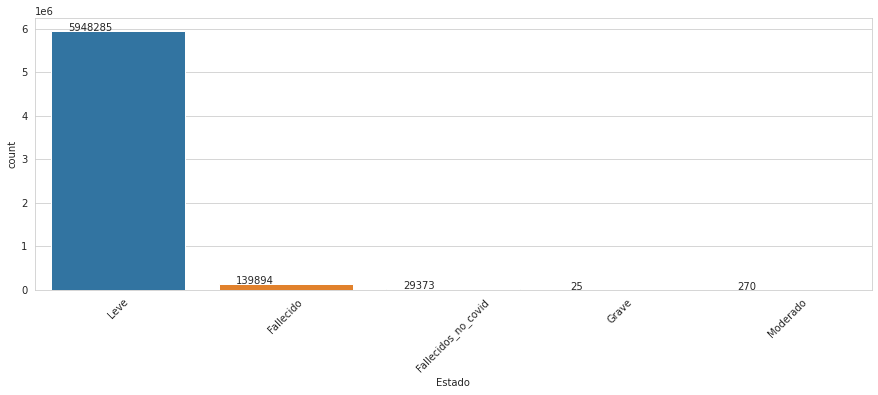

In [19]:
plt.figure(figsize=(15, 5))
ax = sns.set_style('whitegrid')
ax = sns.countplot(x = 'Estado', data = data)

for p in ax.patches: ax.annotate('{}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+50))

plt.xticks(rotation=45)
plt.show()

In [20]:
CPC19 = len(data['Estado'])
CPC19L = len(data[data['Estado'] == 'Leve'])
P = (CPC19L/CPC19)*100

print('Casos positivos de Covid19: ', CPC19)
print('Casos positivos de Covid19 en estado Leve: ', CPC19L)
print('Porcentaje de casos positivos de Covid19 en estado Leve: ', P, '%')

Casos positivos de Covid19:  6117847
Casos positivos de Covid19 en estado Leve:  5948285
Porcentaje de casos positivos de Covid19 en estado Leve:  97.22840404475626 %


**Muestra la relación de la variable objetivo con el género de la persona**

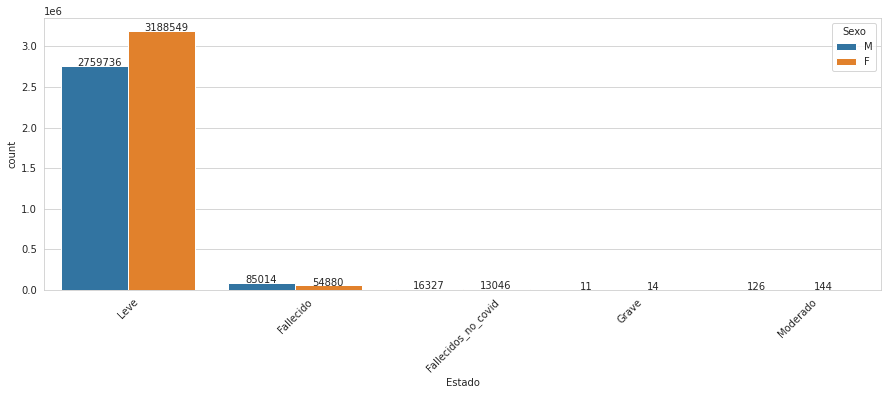

In [21]:
plt.figure(figsize=(15, 5))
ax = sns.countplot(x = 'Estado', data = data, hue = 'Sexo')

for p in ax.patches: ax.annotate('{}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+50))

plt.xticks(rotation=45)
plt.show()

In [22]:
CPC19F = len(data[data['Sexo'] == 'F'])
PF = (CPC19F/CPC19)*100

print('Casos positivos de Covid19 en genero Femenino: ', CPC19F)
print('Porcentaje de casos positivos de Covid19 en genero Femenino: ', PF, '%')

Casos positivos de Covid19 en genero Femenino:  3256633
Porcentaje de casos positivos de Covid19 en genero Femenino:  53.231684283703075 %


**Distribución por edad**

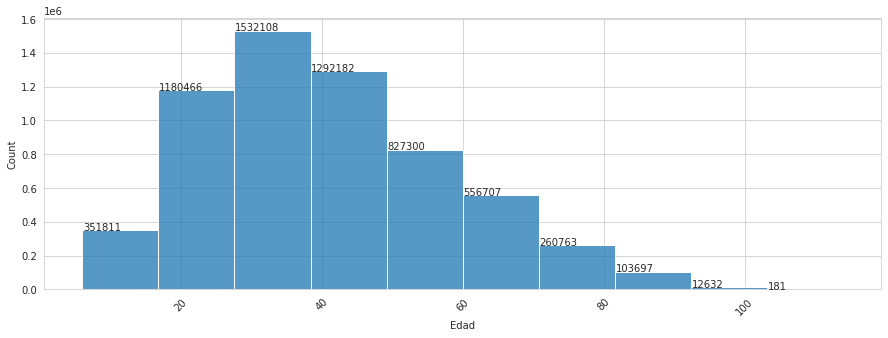

In [23]:
plt.figure(figsize=(15, 5))
ax = sns.histplot(data['Edad'], kde = False, bins = 10)

for p in ax.patches: ax.annotate('{}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+50))

plt.xticks(rotation=45)
plt.show()

In [24]:
CPC19E = len( data[ (data['Edad'] >= 30) & (data['Edad'] <= 40) ] )
PE = (CPC19E/CPC19)*100

print('Casos positivos de Covid19 entre los 30 a 40 años de edad: ', CPC19E)
print('Porcentaje de casos positivos de Covid19 entre los 30 a 40 años de edad: ', PE, '%')

Casos positivos de Covid19 entre los 30 a 40 años de edad:  1623335
Porcentaje de casos positivos de Covid19 entre los 30 a 40 años de edad:  26.534416437678153 %


**Muestra la cantidad de personas según la variable Recuperado**

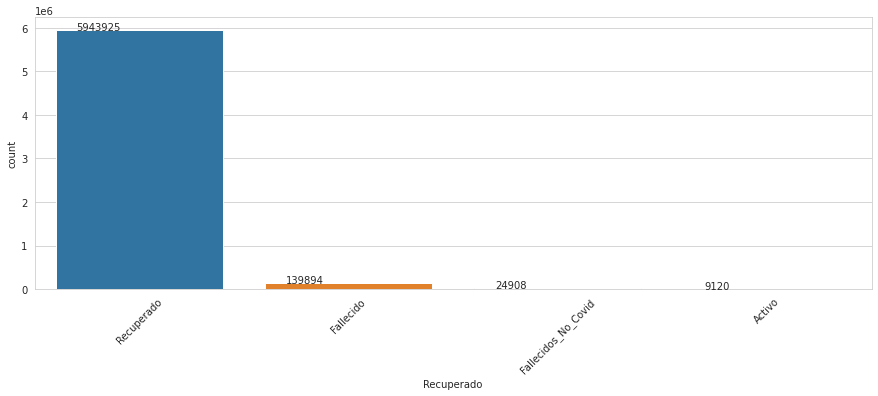

In [25]:
plt.figure(figsize=(15, 5))
ax = sns.countplot(x = 'Recuperado', data = data)

for p in ax.patches: ax.annotate('{}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+50))

plt.xticks(rotation=45)
plt.show()

In [26]:
CPC19R = len(data[data['Recuperado'] >= 'Recuperado'])
PR = (CPC19R/CPC19)*100

print('Casos positivos de Covid19 que se encuentran recuperados: ', CPC19R)
print('Porcentaje de casos positivos de Covid19 que se encuentran recuperados: ', PR, '%')

Casos positivos de Covid19 que se encuentran recuperados:  5943925
Porcentaje de casos positivos de Covid19 que se encuentran recuperados:  97.15713714318125 %


**Muestra la relación de la variable Recuperado con el género de la persona**

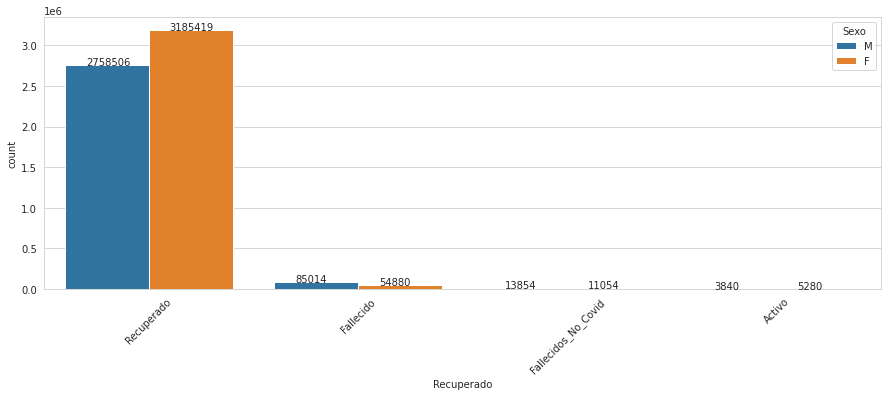

In [27]:
plt.figure(figsize=(15, 5))
ax = sns.countplot(x = 'Recuperado', data = data, hue = 'Sexo')

for p in ax.patches: ax.annotate('{}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+50))

plt.xticks(rotation=45)
plt.show()

**Distribución por edad de personas recuperadas**

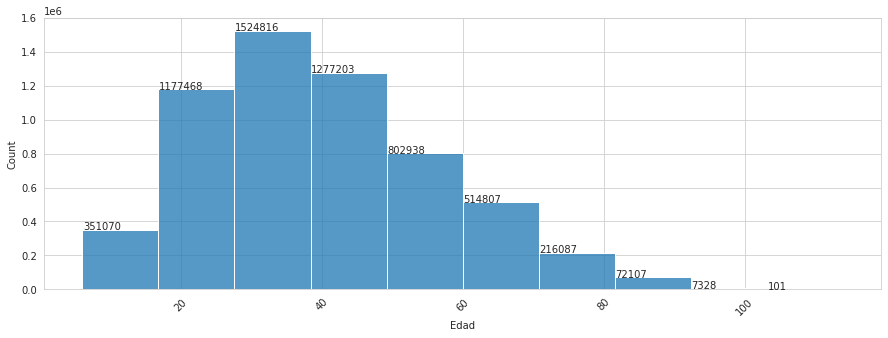

In [28]:
plt.figure(figsize=(15, 5))
ax = sns.histplot(data = data[data['Recuperado'] == 'Recuperado'], x = 'Edad', kde = False, bins = 10)

for p in ax.patches: ax.annotate('{}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+50))

plt.xticks(rotation=45)
plt.show()

**Distribución por edad de personas fallecidas**

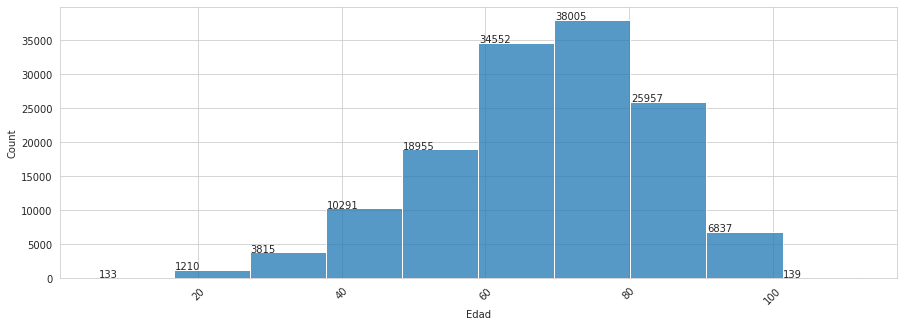

In [29]:
plt.figure(figsize=(15, 5))
ax = sns.histplot(data = data[data['Recuperado'] == 'Fallecido'], x = 'Edad', kde = False, bins = 10)

for p in ax.patches: ax.annotate('{}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+50))

plt.xticks(rotation=45)
plt.show()

**Distribución de ubicación del caso**

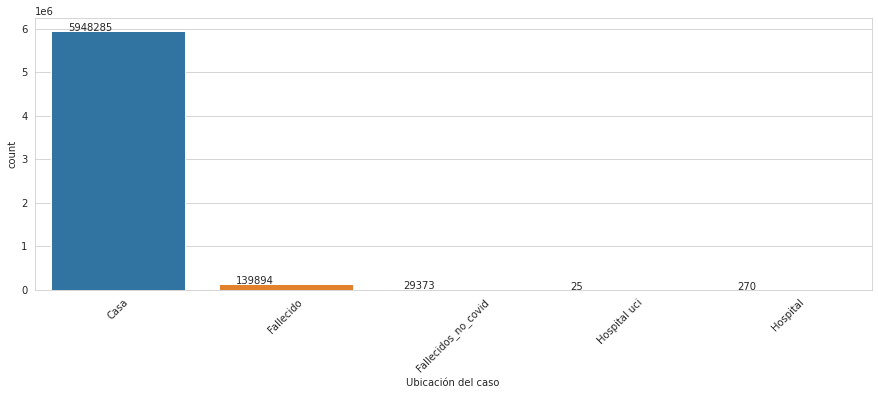

In [65]:
plt.figure(figsize=(15, 5))
ax = sns.countplot(data = data, x = 'Ubicación del caso')

for p in ax.patches: ax.annotate('{}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+50))

plt.xticks(rotation=45)
plt.show()

In [68]:
Ubi = len(data[data['Ubicación del caso'] == 'Casa'])
PU = (Ubi/CPC19)*100

print('Casos positivos de Covid19 que se encuentran en casa: ', Ubi)
print('Porcentaje de casos positivos de Covid19 que se encuentran en casa: ', PU, '%')

Casos positivos de Covid19 que se encuentran en casa:  5948285
Porcentaje de casos positivos de Covid19 que se encuentran en casa:  97.22840404475626 %


**Distribucion de casos positivos por mes**

In [30]:
data['Mes'] = data['Fecha de notificación'].dt.month
data['Año'] = data['Fecha de notificación'].dt.year

In [31]:
Meses = data.groupby(['Año','Mes']).count()[['ID de caso']]
Meses.reset_index(inplace = True)
Meses.columns = ['Año','Mes', 'Casos']
Meses['Mes'] = Meses['Mes'].map({1:'Enero', 2:'Febrero', 3:'Marzo', 4:'Abril', 5:'Mayo', 6:'Junio', 7:'Julio', 8:'Agosto', 9:'Septiembre', 10:'Octubre', 11:'Noviembre', 12:'Diciembre'})

In [32]:
Año = Meses.groupby(['Año']).sum().sort_values(by="Casos", ascending=False)
Año

,Casos
Año,
2021,3521428
2020,1756967
2022,839452


In [33]:
Meses_Total = data.groupby(['Año','Mes']).count()[['ID de caso']].reset_index()
Meses_Total.columns = ['Año','Mes', 'Casos']
Meses_Total = Meses_Total.sort_values(by='Mes')
Meses_Total = Meses_Total.groupby(['Mes']).sum().reset_index().drop(['Año'], axis=1)
Meses_Total['Mes'] = Meses_Total['Mes'].map({1:'Enero', 2:'Febrero', 3:'Marzo', 4:'Abril', 5:'Mayo', 6:'Junio', 7:'Julio', 8:'Agosto', 9:'Septiembre', 10:'Octubre', 11:'Noviembre', 12:'Diciembre'})
Meses_Total

,Mes,Casos
0,Enero,1113034
1,Febrero,213721
2,Marzo,227420
3,Abril,507246
4,Mayo,661349
5,Junio,951093
6,Julio,656160
7,Agosto,360230
8,Septiembre,256250
9,Octubre,306550


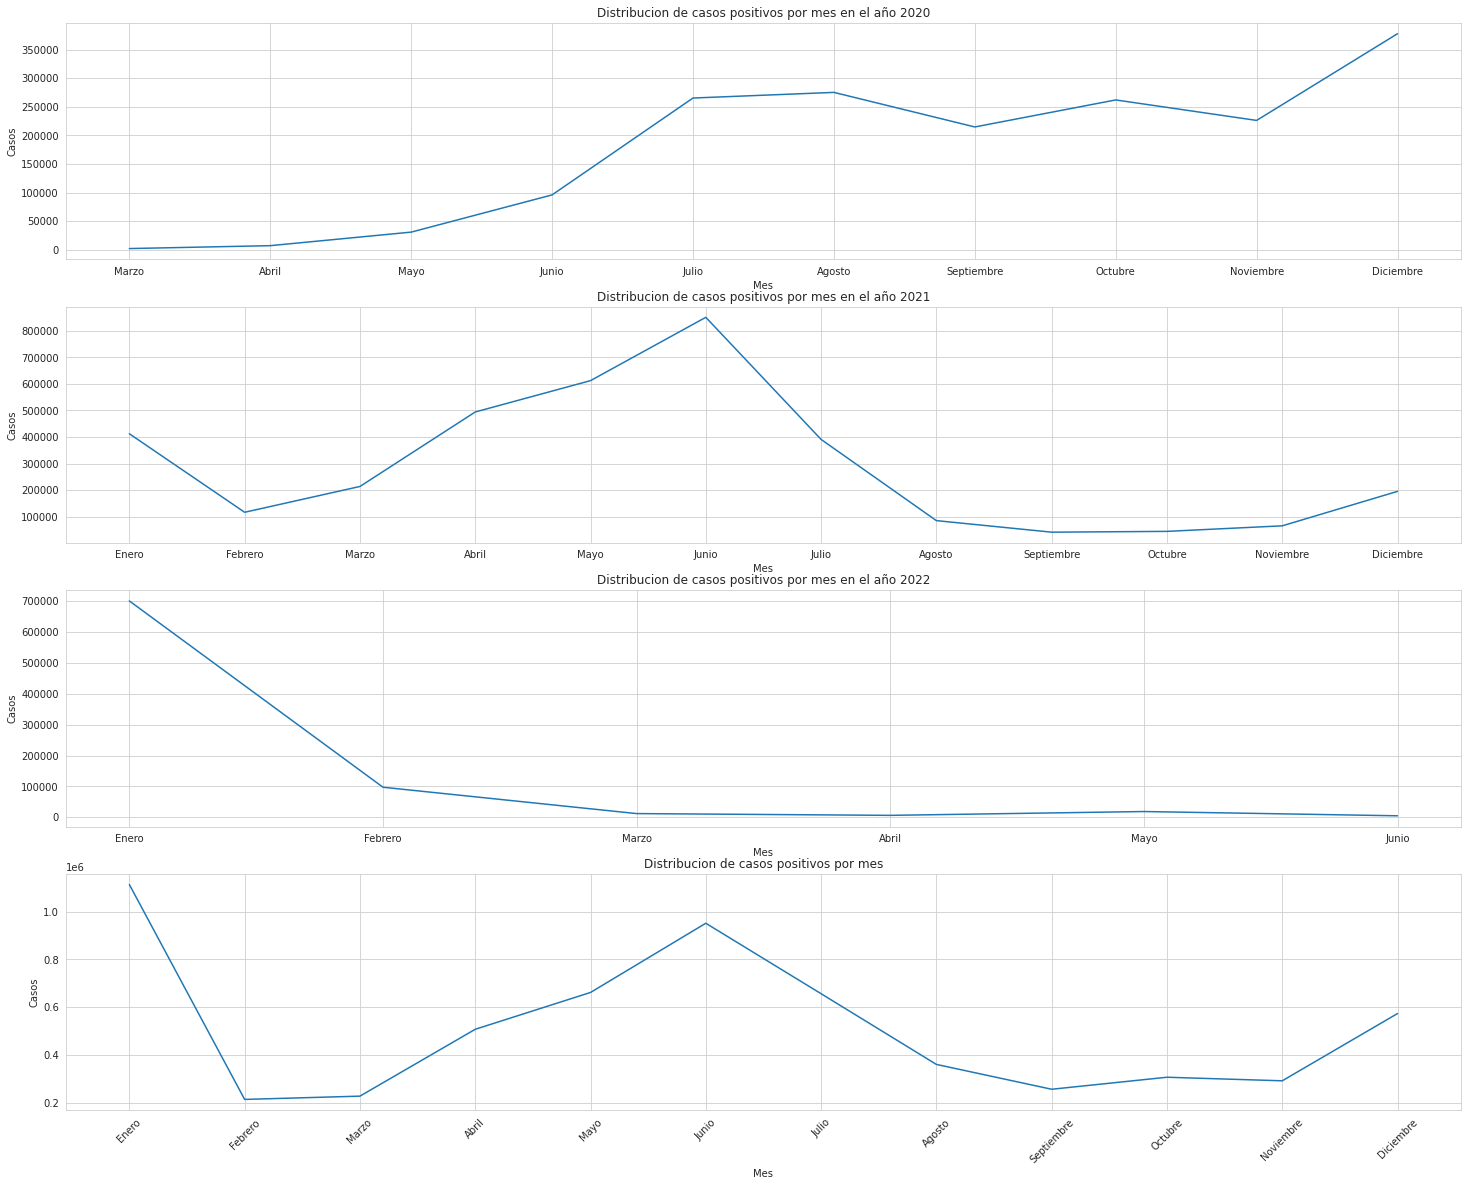

In [34]:
plt.figure(figsize=(25, 20))

plt.subplot(4, 1, 1)
sns.lineplot(data = Meses[Meses['Año'] == 2020], x = 'Mes', y = 'Casos')
plt.title('Distribucion de casos positivos por mes en el año 2020')

plt.subplot(4, 1, 2)
sns.lineplot(data = Meses[Meses['Año'] == 2021], x = 'Mes', y = 'Casos')
plt.title('Distribucion de casos positivos por mes en el año 2021')

plt.subplot(4, 1, 3)
sns.lineplot(data = Meses[Meses['Año'] == 2022], x = 'Mes', y = 'Casos')
plt.title('Distribucion de casos positivos por mes en el año 2022')

plt.subplot(4, 1, 4)
sns.lineplot(data = Meses_Total, x = 'Mes', y = 'Casos')
plt.title('Distribucion de casos positivos por mes')

plt.xticks(rotation=45)
plt.show()

**Selecciono las variable que creo necesarias para el modelo**

In [69]:
Data_Final = data[['Código DIVIPOLA departamento', 'Código DIVIPOLA municipio', 'Edad', 'Sexo', 'Tipo de contagio', 'Ubicación del caso', 'Estado', 'Recuperado', 'Tipo de recuperación', 'Pertenencia étnica']]

**Convertimos las Columnas necesarias para el modelo en valores enteros**

In [70]:
Data_Final['Estado'] = Data_Final['Estado'].map({'Leve': 0, 'Fallecido': 1, 'Fallecidos_no_covid':2, 'Moderado':3, 'Grave':4})

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [72]:
Data_Final = Data_Final.rename(columns={'Código DIVIPOLA departamento':'Departamento', 'Código DIVIPOLA municipio':'Municipio'})
Data_Final['Sexo'] = Data_Final['Sexo'].map({'M': 1, 'F': 0})
Data_Final = pd.get_dummies(Data_Final, columns=['Tipo de recuperación'], prefix = "Tipo_Recuperación")
Data_Final = pd.get_dummies(Data_Final, columns=['Tipo de contagio'], prefix = "Tipo_Contagio")
Data_Final = pd.get_dummies(Data_Final, columns=['Ubicación del caso'], prefix = "Ubicación_Caso")
Data_Final = pd.get_dummies(Data_Final, columns=['Recuperado'], prefix = "Recuperado")
Data_Final['Pertenencia étnica'] = Data_Final['Pertenencia étnica'].astype('int')

In [78]:
Data_Final.describe()

,Departamento,Municipio,Edad,Sexo,Estado,Pertenencia étnica,Tipo_Recuperación_No_Registrado,Tipo_Recuperación_PCR,Tipo_Recuperación_Tiempo,Tipo_Contagio_Comunitaria,Tipo_Contagio_Importado,Tipo_Contagio_Relacionado,Ubicación_Caso_Casa,Ubicación_Caso_Fallecido,Ubicación_Caso_Fallecidos_no_covid,Ubicación_Caso_Hospital,Ubicación_Caso_Hospital uci,Recuperado_Activo,Recuperado_Fallecido,Recuperado_Fallecidos_No_Covid,Recuperado_Recuperado
count,6.117847e+06,6.117847e+06,6.117847e+06,6.117847e+06,6.117847e+06,6.117847e+06,6.117847e+06,6.117847e+06,6.117847e+06,6.117847e+06,6.117847e+06,6.117847e+06,6.117847e+06,6.117847e+06,6.117847e+06,6.117847e+06,6.117847e+06,6.117847e+06,6.117847e+06,6.117847e+06,6.117847e+06
mean,1.350333e+03,2.851354e+04,3.974448e+01,4.676832e-01,3.261768e-02,5.910778e+00,2.842863e-02,1.519638e-01,8.196076e-01,6.867918e-01,5.982497e-04,3.126100e-01,9.722840e-01,2.286654e-02,4.801199e-03,4.413317e-05,4.086405e-06,1.490721e-03,2.286654e-02,4.071367e-03,9.715714e-01
std,5.944257e+03,2.630588e+04,1.820980e+01,4.989546e-01,2.036419e-01,5.906428e-01,1.661940e-01,3.589858e-01,3.845140e-01,4.637983e-01,2.445183e-02,4.635569e-01,1.641578e-01,1.494780e-01,6.912415e-02,6.643134e-03,2.021482e-03,3.858106e-02,1.494780e-01,6.367725e-02,1.661940e-01
min,5.000000e+00,5.001000e+03,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.100000e+01,1.100100e+04,2.700000e+01,0.000000e+00,0.000000e+00,6.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
50%,1.700000e+01,1.100100e+04,3.700000e+01,0.000000e+00,0.000000e+00,6.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,6.800000e+01,5.200100e+04,5.200000e+01,1.000000e+00,0.000000e+00,6.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
max,4.700100e+04,9.977300e+04,1.140000e+02,1.000000e+00,4.000000e+00,6.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


**Mapa de correlaciones**

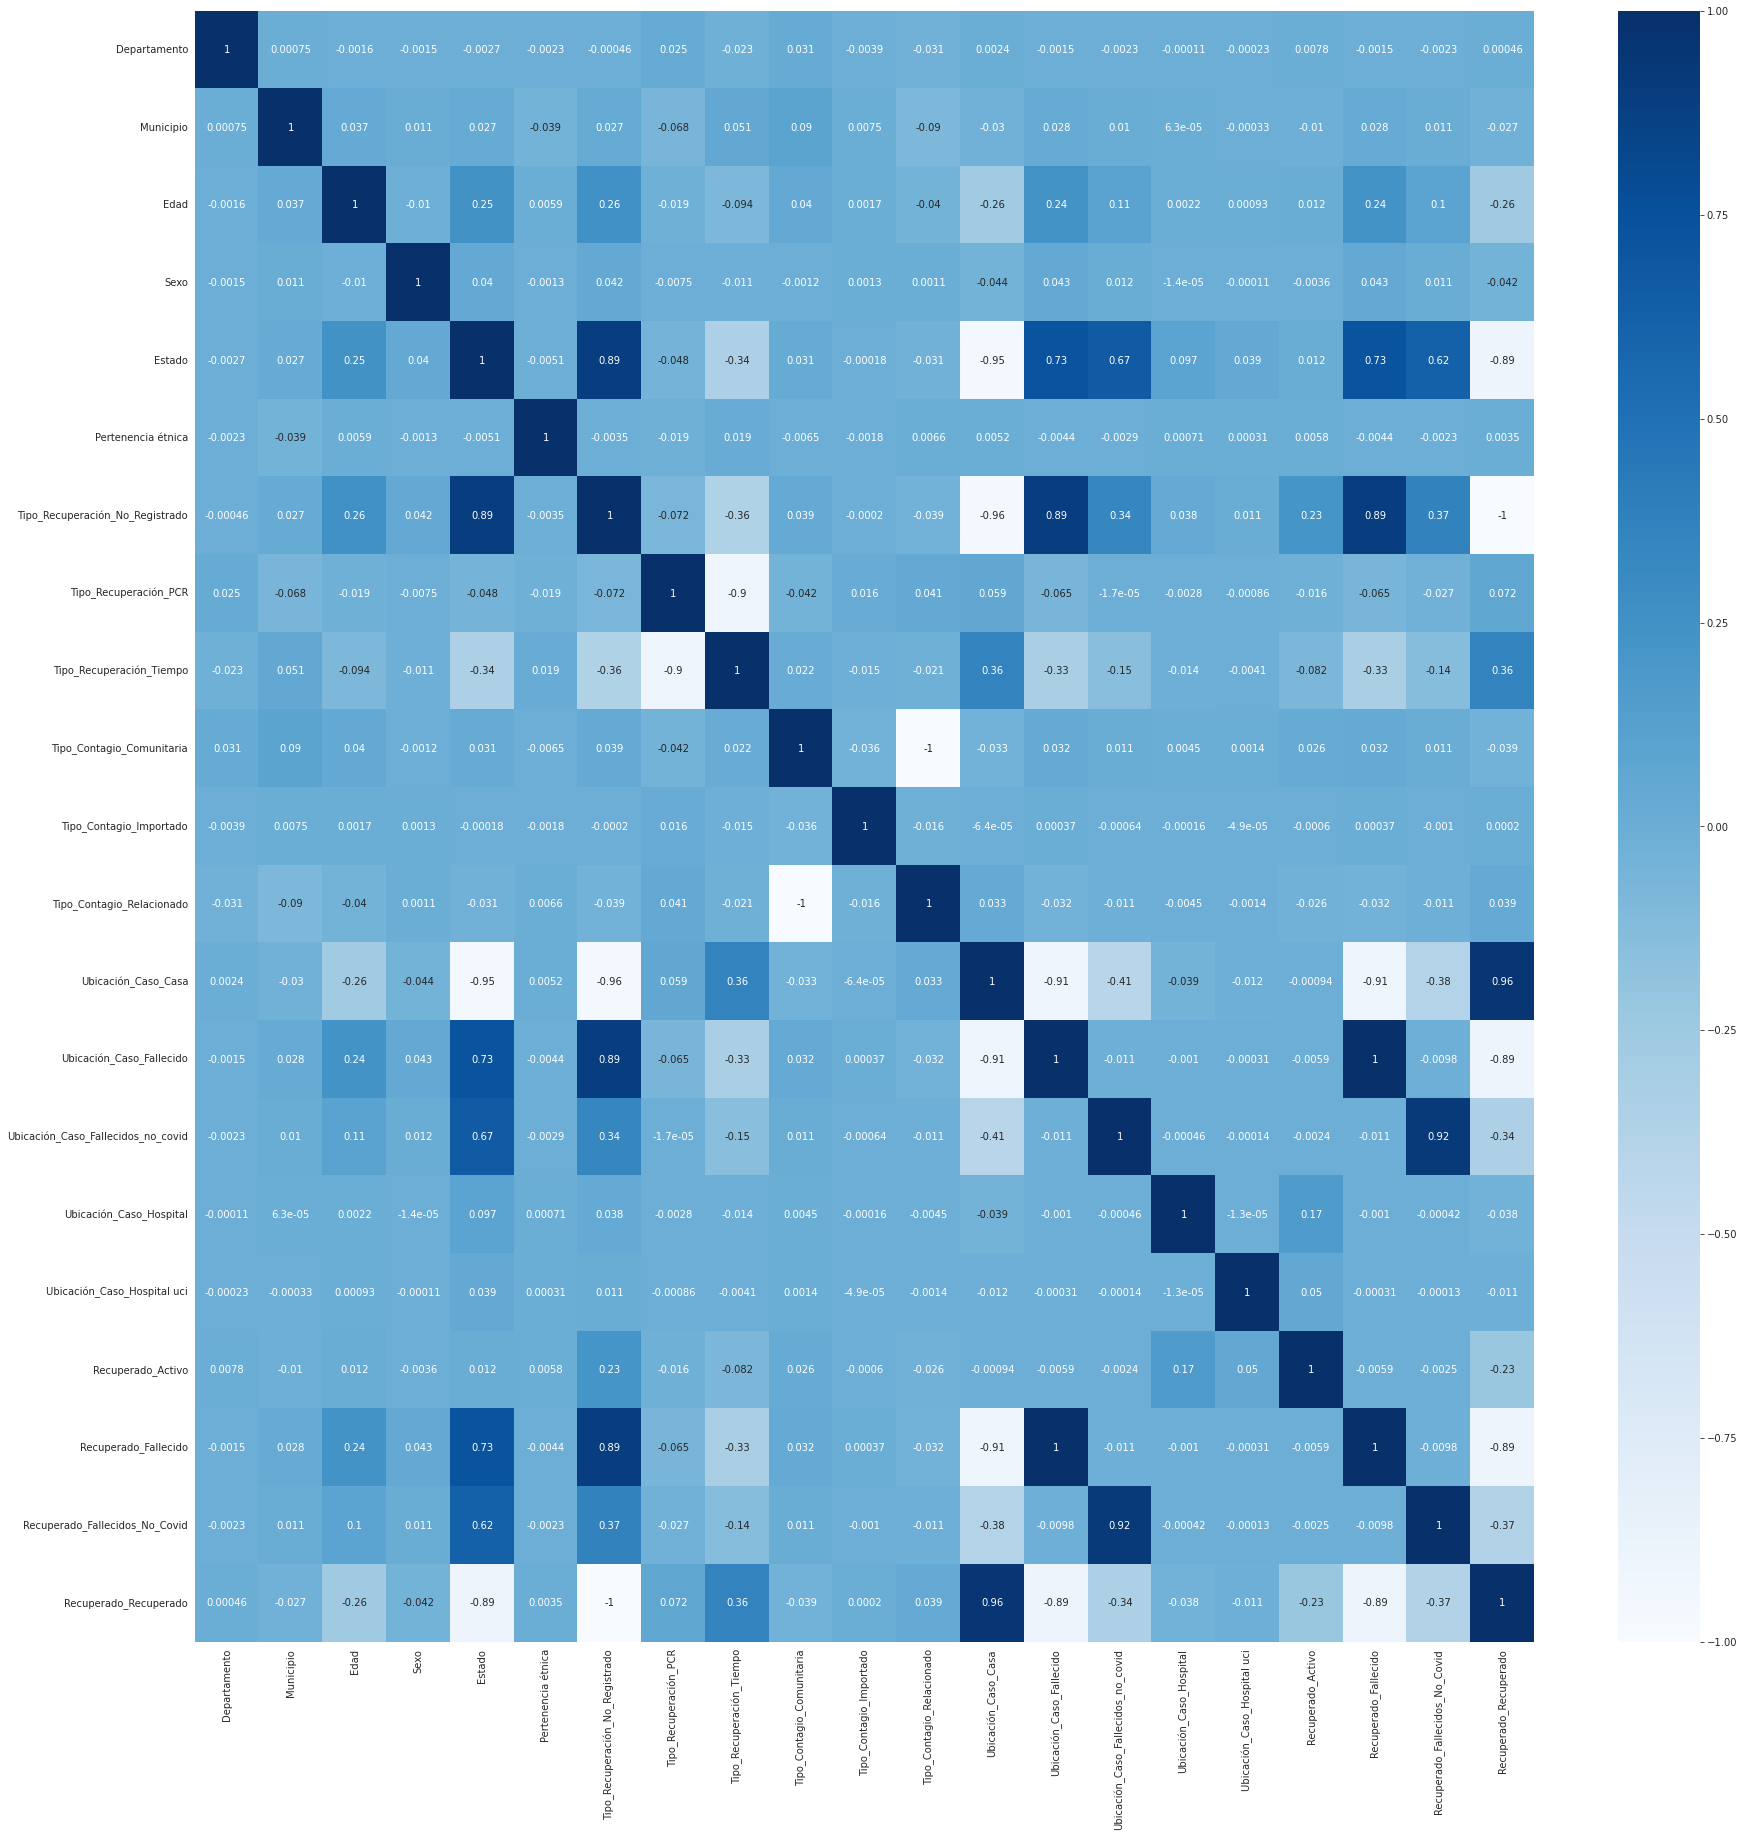

In [77]:
plt.figure(figsize=(30, 30))

sns.heatmap(Data_Final.corr(), annot=True, cmap = 'Blues')
plt.show()

# **Conclusiones EDA**

Del anterior EDA se concluye:

* El 97.22% de los casos positivos para Covid19 en Colombia registran un estado Leve
* El primer caso registrado de Covid19 en Colombia es el 2020-03-02
* El 53.23% de los casos positivos para Covid19 en Colombia son mujeres
* El 26.53% de los casos positivos para Covid19 en Colombia se encuentran entre los 30 a 40 años de edad
* El 97.15% de los casos positivos para Covid19 en Colombia se encuentran recuperados, la mayoria son mujeres
* La mayoria de recuperados del Covid19 se encuentran entre los 20 a 40 años de edad
* La mayoria de fallecidos por Covid19 se encuentran entre los 60 a 80 años de edad
* El 97.22% de los casos positivos para Covid19 en Colombia se encuentran en ubicados en casa
* En el mes de diciembre del año 2020 fue cuando se registro la mayor cantidad de casos positivos para Covid19
* En el mes de junio del año 2021 fue cuando se registro la mayor cantidad de casos positivos para Covid19
* En lo que vamos del año 2022 el mes de enero es donde se encuentran la mayor cantidad de casos positivos para Covid19 registrados

# **Construcción del modelo**

**Creación del dataset**

In [142]:
from sklearn.preprocessing import OneHotEncoder

In [145]:
X = Data_Final.drop(['Estado'], axis = 1).values
Y = Data_Final['Estado'].values

In [146]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)

In [150]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(4894277, 20)
(1223570, 20)
(4894277,)
(1223570,)


In [147]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [148]:
def train_and_view_results(model, model_name):
    """
    Función para entrenar un modelo, hacer predicciónes y
    visualizar el rendimiento.

    :param model: Modelo a entrenar y evaluar
    :param model_name: Nombre del algoritmo entrenado 
    :return: Matriz de confusión y reporte de clasificación
    """
    # Train and Predict
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)

    # Matriz de confusión y reporte de clasificación
    cm = confusion_matrix(Y_test, Y_pred)
    cr = classification_report(Y_test, Y_pred)
    sns.heatmap(cm,annot = True, cmap='viridis')
    plt.title(model_name)
    plt.show()
    print('\n')
    print(cr)
    print('='*50)
    print('\n\n')

**Entrenamiento de algoritmos de machine learning**

In [ ]:
# Algoritmo: Naïve Bayes Algorithm
model = GaussianNB()
train_and_view_results(model, "GaussianNB")

# Algoritmo: Decision Tree
model = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
train_and_view_results(model, "DecisionTreeClassifier")

# Algoritmo: Nearest Neighbor algorithm
model = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
train_and_view_results(model, "KNeighborsClassifier")

# Algoritmo: Kernel SVM
model = SVC(kernel = 'rbf', random_state = 0)
train_and_view_results(model, "Kernel Support Vector Machine")

# Algoritmo: Random Forest Classification
model = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
train_and_view_results(model, "RandomForestClassifier")

#Algoritmo: Logistic Regression
model = LogisticRegression(random_state = 0)
train_and_view_results(model, "LogisticRegression")

#Algoritmo: Linear Regression
model = LinearRegression()
train_and_view_results(model, "LinearRegression")

**Entrenamiento con Deep Learning**

In [151]:
model = Sequential()
model.add(Dense(12, input_dim=20, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.fit(X_train, Y_train, epochs=100, batch_size=128)

In [ ]:
Y_pred = model.predict(X_test)

In [ ]:
# Evaluación del modelo DNN
_, accuracy = model.evaluate(X_test, Y_test)
print('Accuracy: %.2f' % (accuracy*100))

In [ ]:
def map_pred(val):
    """
    Función para mapear las predicciones
    """
    if val > 0.5: return 1
    else: return 0

**Resultado**

In [ ]:
# Matriz de confusión y reporte de clasificación
cm = confusion_matrix(Y_test, [map_pred(i[0]) for i in Y_pred])
cr = classification_report(Y_test, [map_pred(i[0]) for i in Y_pred])
sns.heatmap(cm,annot = True, cmap='viridis')
plt.title('Red Neuronal Densamente Conectada')
plt.show()
print('\n')
print(cr)